In [24]:
import os
import glob
from shapely.geometry import Point, Polygon
import pandas as pd
import momepy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:
data_dir = r'D:\Projects\superparcels\data\urban'

In [83]:
streets = gpd.read_file(os.path.join(data_dir, 'main_streets_cleaned_boco_urban.shp'))
parcels = gpd.read_file(os.path.join(data_dir, 'cleaned_canidate_parcels.shp'))


In [84]:
print(parcels.columns)

Index(['state_code', 'cnty_code', 'OWNER', 'std_addr', 'cluster', 'geometry'], dtype='object')


In [85]:
aoi_parcels = parcels.dissolve(by='OWNER')
aoi_parcels = aoi_parcels.explode(ignore_index=False).reset_index()
#aoi_parcels.to_file(os.path.join(data_dir, 'aoi_parcels.shp'))
aoi_parcels = aoi_parcels[['OWNER', 'level_1', 'std_addr','geometry']]

C:\Users\abreunig\AppData\Local\Temp\2\ipykernel_28332\970559288.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  aoi_parcels = aoi_parcels.explode(ignore_index=False).reset_index()


In [86]:
aoi_parcels.to_file(os.path.join(data_dir, 'aoi_parcels.shp'))

In [82]:
candiates = aoi_parcels
canidates.to_file(os.path.join(data_dir, 'aoi_parcels.shp'))

In [30]:
#non_canidates = aoi_parcels[aoi_parcels['OWNER'].map(aoi_parcels['OWNER'].value_counts()) == 1]
#non_canidates['OWNER'].value_counts()

OWNER
1827GROVE                        1
MERRILL AGLUSTROM                1
MERYEM CERSOZ                    1
MERUNNASSER                      1
MERSCH PIETER LAWRENCEVAN DER    1
                                ..
GRANTCOBURN                      1
GRANTBOLASNY                     1
GRANTBESSER                      1
GRANT TYAMAKI                    1
ZULFIAABDRASHITOVA               1
Name: count, Length: 19834, dtype: int64

In [32]:
print(canidates.shape)
print(non_canidates.shape)

(4041, 4)
(19834, 4)


In [ ]:
#canidates.to_file(os.path.join(data_dir, 'canidates_boco_urban.shp'))

In [64]:
canidates = canidates.to_crs(parcels.estimate_utm_crs().to_epsg())

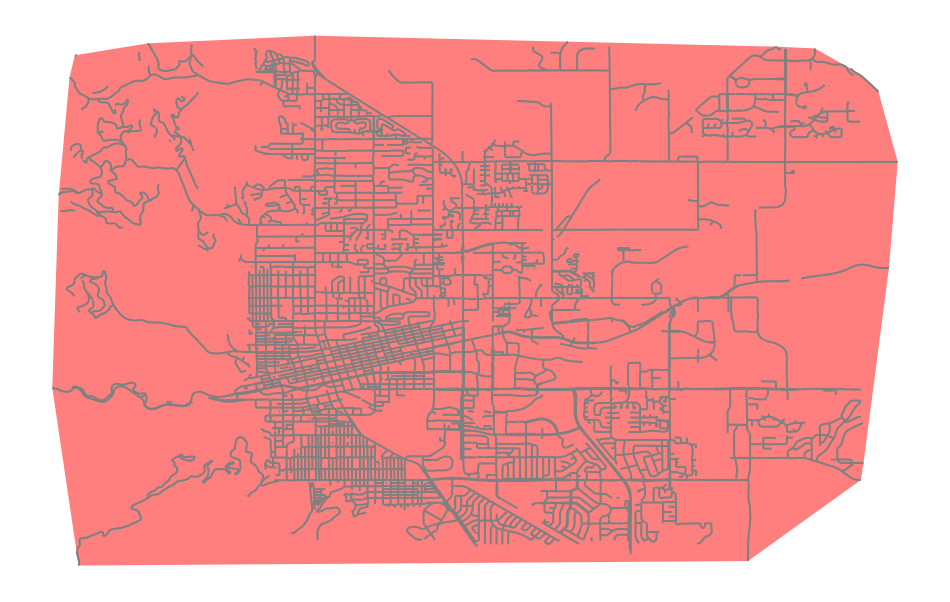

In [65]:
convex_hull = streets.unary_union.convex_hull
# visualize
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, color='grey')
gpd.GeoSeries([convex_hull]).plot(ax=ax, color='red', alpha=0.5)
plt.axis('off')
plt.show()

d:\mini-forge\envs\growth_model\Lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


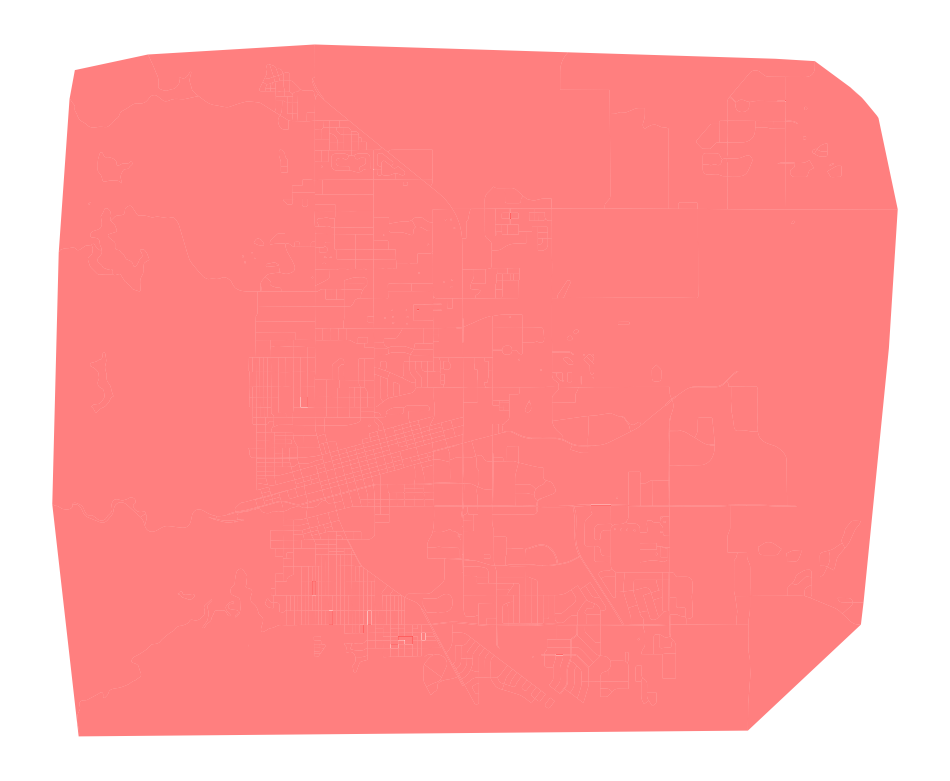

In [66]:
enclosures = momepy.enclosures(streets, limit=convex_hull)
# visualize
fig, ax = plt.subplots(figsize=(12, 12))
enclosures.plot(ax=ax, color='red', alpha=0.5)
plt.axis('off')
plt.show()

In [67]:
parcels.estimate_utm_crs().to_epsg()

32613

In [68]:
enclosures = enclosures.to_crs(parcels.estimate_utm_crs().to_epsg())

In [40]:
enclosures.to_file(os.path.join(data_dir, 'enclosures_boco_urban_wadd.shp'))

In [69]:
canidates.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [70]:
enclosures.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [71]:
canidates.to_file(os.path.join(data_dir, 'canidates_boco_urban.shp'))

In [45]:
# drop duplicate geometries
canidates.normalize()
canidates_nodups = canidates.drop_duplicates('geometry')
print(canidates_nodups.shape)
print(canidates.shape)

(2645, 4)
(4041, 4)


In [46]:
canidates_nodups.to_file(os.path.join(data_dir, 'canidates_nodups_boco_urban.shp'))

In [72]:
enclosed_tess = momepy.Tessellation(canidates, unique_id='OWNER', enclosures=enclosures)


d:\mini-forge\envs\growth_model\Lib\site-packages\momepy\elements.py:457: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = buildings.sindex.query_bulk(


In [73]:
tess = enclosed_tess.tessellation

In [74]:
tess = tess[tess.geom_type != 'GeometryCollection']
tess.geom_type.unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

In [75]:
tess.to_file(os.path.join(data_dir, 'tess_urban.shp'))

In [76]:
canidate_superparcels = tess.dissolve(by='OWNER')
canidate_superparcels = canidate_superparcels.explode(index_parts=False).reset_index()

In [77]:
canidate_superparcels['SP_ID'] = canidate_superparcels['OWNER'].factorize()[0]

In [78]:
canidate_superparcels.to_file(os.path.join(data_dir, 'sp_urban.shp'))